# Amsterdam: SQL queries, times series, reviews, verifications and licenses 

Let's import useful packages:

In [2]:
import gzip
import json
import csv
import sqlite3
import pandas as pd
import numpy as np
from scipy import stats

Visualization tools:

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import folium

In [4]:
import sys
# !{sys.executable} -m pip install -U folium

In this last analysis, we create a database in Python using *sqlite3* importing a DataFrame using Pandas. The step 1 is create a database called BookingsDB.

In [6]:
conn = sqlite3.connect('../Data/database/BookingsDB.db') 

In [7]:
c = conn.cursor()

In [8]:
read_listing = pd.read_csv('../Data/raw/listings.csv.gz', 
                      compression='gzip',
                      error_bad_lines=False, 
                      low_memory=False)

In [18]:
read_listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

In [13]:
read_listing.loc[:, 'calendar_updated': 'calendar_last_scraped'].head(2)

,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped
0,2 months ago,t,0,0,0,0,2019-12-08
1,yesterday,t,4,21,51,198,2019-12-08


In [9]:
read_listing.to_sql('LISTINGS', conn, if_exists='append', index = False) # Insert the values from the csv file into the table 'CLIENTS' 

In [35]:
c.execute('''
        SELECT calendar_updated, COUNT(*) 
        FROM LISTINGS 
        GROUP BY calendar_updated
        HAVING COUNT(*) > 500
        ORDER BY COUNT(*) DESC
''')

In [36]:
for i in c.fetchall():
    print(i)

('today', 1396)
('2 weeks ago', 1248)
('3 months ago', 1193)
('2 months ago', 1168)
('a week ago', 974)
('4 months ago', 822)
('3 weeks ago', 803)
('5 months ago', 696)
('4 weeks ago', 667)
('yesterday', 658)
('5 weeks ago', 571)
('3 days ago', 512)


In [47]:
c.execute('''
        SELECT availability_30, COUNT(*) 
        FROM LISTINGS 
        GROUP BY availability_30
        ORDER BY availability_30
''')

In [48]:
for i in c.fetchall():
    print(i)

(0, 12624)
(1, 390)
(2, 357)
(3, 447)
(4, 471)
(5, 397)
(6, 546)
(7, 358)
(8, 338)
(9, 307)
(10, 293)
(11, 247)
(12, 225)
(13, 235)
(14, 201)
(15, 201)
(16, 173)
(17, 180)
(18, 202)
(19, 166)
(20, 167)
(21, 144)
(22, 128)
(23, 187)
(24, 132)
(25, 125)
(26, 108)
(27, 152)
(28, 131)
(29, 194)
(30, 199)


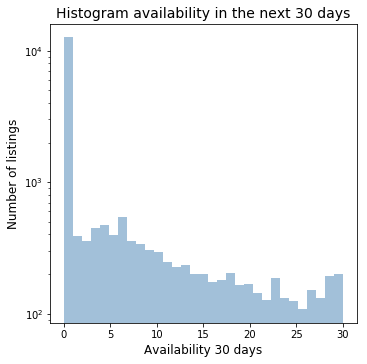

In [59]:
_ = plt.figure(figsize=(5.5, 5.5))
_ = plt.yscale('log')
_ = plt.hist(read_listing.availability_30.dropna(), bins=31, alpha=0.5, facecolor='steelblue')
_ = plt.xlabel('Availability 30 days', size=12)
_ = plt.ylabel('Number of listings', size=12)
_ = plt.title('Histogram availability in the next 30 days', size=14)
# _ = plt.xlim(-0.5, 5.5)

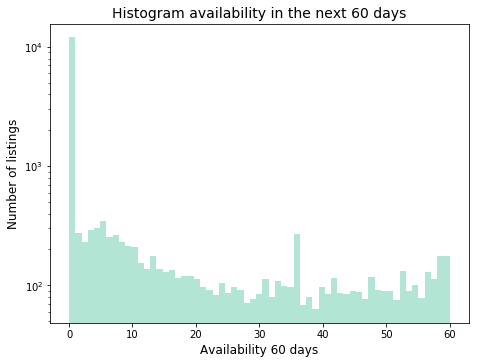

In [67]:
_ = plt.figure(figsize=(7.5, 5.5))
_ = plt.yscale('log')
_ = plt.hist(read_listing.availability_60.dropna(), bins=61, alpha=0.5, facecolor='mediumaquamarine')
_ = plt.xlabel('Availability 60 days', size=12)
_ = plt.ylabel('Number of listings', size=12)
_ = plt.title('Histogram availability in the next 60 days', size=14)

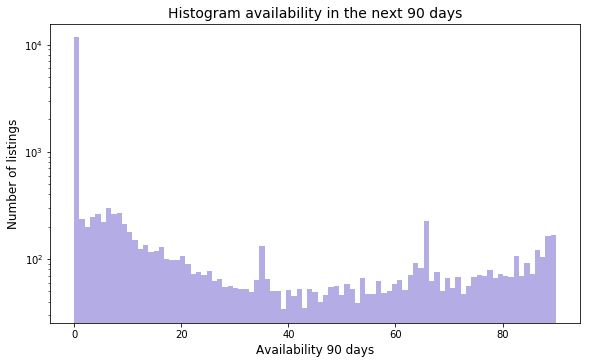

In [69]:
_ = plt.figure(figsize=(9.5, 5.5))
_ = plt.yscale('log')
_ = plt.hist(read_listing.availability_90.dropna(), bins=91, alpha=0.5, facecolor='slateblue')
_ = plt.xlabel('Availability 90 days', size=12)
_ = plt.ylabel('Number of listings', size=12)
_ = plt.title('Histogram availability in the next 90 days', size=14)
# _ = plt.xlim(-0.5, 5.5)

A brief inspection of columns enable us to split them according to the following **different categories of information**:

1. **General information of booking**: id, name, summary, description, space, experiences_offered, neighborhood overview, notes, transit, access, interaction, house_rules. To access that, select columns from `id` to `house_rules`.

2. **Host information**: id, name, location, about, response time, response rate, acceptance rate, listings count, verifications. In this case, select columns from `host_id` to `host_identity_verified`.

3. All about the **neighborhood**: city, state, market, cleansed. Extract this information selecting columns from `street` to `is_location_exact`.

4. Details of **property and conditions** are between the columns `property_type` and `maximum_nights_avg_ntm`.

5. **Calendar updates and availability** the next 30, 60 and 90 days, for instances. You can find this information between the columns `calendar_updated` and `calendar_last_scraped`.

6. **Reviews**: first and last review, number of reviews, scores rating, scores per accuracy, cleanliness, checkin, communication, location and value. Columns from `number of reviews` to `review_scores_value`.

7. **Verifications and licenses**: require guest profile picture, phone verification, cancellation policy, instant bookeable. Columns from `requires_license` to `require_guest_phone_verification`.

8. **Host listings counts** and reviews per month. Select from `calculated_host_listings_count` to `reviews_per_month`.